## Energy signature method

The energy signature of a building is a very simple model of its energy consumption profile (all energies combined) as a function of the outdoor temperature. Provided a long enough monitoring period of a building, the method is able to provide a crude estimation of its heat loss coefficient (HLC), and to separate its energy consumption into two (or three) main parts: heating and/or cooling, and other uses. Using a trained energy signature model to predict the energy use is possible, but comes with a large uncertainty.

The appeal of this method is that the data we need to train the model is very easy to obtain:
* Outdoor air temperature
* Energy consumption

We don't even need a short time step between each meter reading, as the data will be resampled (averaged) over samples of one or several days.

## The model

The model is written here in terms of the average power $\Phi$ (W) between energy readings (kWh).

The total electrical power used in a building is decomposed into three parts: the baseline consumption $\Phi_b$ (lighting, appliances, DHW...), heating power $\Phi_h$ and cooling power $\Phi_c$ 

$$ \Phi = \Phi_b + \Phi_h + \Phi_c $$

The energy signature method relates the heating and cooling energy use to easily measured environmental parameters, typically the outdoor temperature. The model relies on the following, very convenient hypotheses:
* Steady-state: each data point is the average of readings over a sufficiently long period (several days), so that dynamic effects can be overlooked.
* The baseline consumption $\Phi_b$ is constant over this broad sampling frequency.
* The indoor temperature is assumed to be quasi-constant, so that heating only is needed when the outdoor temperature $T_e$ is lower than a base temperature $T_{b1}$. The heating power is then only proportional to the HLC.
* The influence of all other environmental factors is neglected.

The heating power is then approached by the following equations:

$$ \Phi_h = \mathrm{HLC}_1 \, (T_{b1}-T_e) \quad \mathrm{if} \quad T_e \leq T_{b1} $$
$$ \Phi_h = 0 \quad \mathrm{if} \quad T_e > T_{b1} $$

<img src='figures/epa01_energy_signature.png' width=250 />

If the building has air conditioning, the same relation can be assumed for cooling, if the outdoor temperature exceeds a threshold $T_{b2}$:

$$ \Phi_c = 0 \quad \mathrm{if} \quad T_e < T_{b2} $$
$$ \Phi_c = \mathrm{HLC}_2 \, (T_e - T_{b2}) \quad \mathrm{if} \quad T_e \geq T_{b2} $$

The model therefore has either three or five unknown parameters:
* The baseline power $\Phi_b$
* The heat loss coefficient HLC, which may have a different value in heating than in cooling conditions
* One or two threshold temperatures $T_b$

## The data

The data used in this example to illustrate the energy signature method is the hourly energy consumption and outdoor air temperature data for 11 commercial buildings (office/retail), publicly available here:

https://openei.org/datasets/dataset/consumption-outdoor-air-temperature-11-commercial-buildings

The code written below supposes that the data files have been downloaded and saved to a `/data` folder. We are only going to use three of the available data files, which are three consecutive years from a single office building: `building60preoffice.csv`, `building61duringoffice.csv` and `building62postoffice.csv`.

It starts by some imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

A data analysis exercise usually starts by taking a look at the formatting of the data files.

In [2]:
df = pd.read_csv('data/building60preoffice.csv')
df.head()

,Date,OAT,Building 6 kW
0,1/2/2009 0:00,41.6,23.3
1,1/2/2009 1:00,40.9,23.1
2,1/2/2009 2:00,39.5,23.7
3,1/2/2009 3:00,36.3,29.1
4,1/2/2009 4:00,32.8,35.6


The datafile is already "clean" with no missing value (one can check this with `np.any(pd.isna(df))` for instance). The only data processing we will do before defining and training the model is:
* Translating the `Date` column into a datetime object which Python understands as temporal data
* Converting the outdoor air temperature `OAT` from (F) to (C) because the data originates from the USA
* Averaging the data over periods of one day
* Noting the day of the week, because this factor usually has an impact on the consumption of retail and office buildings

In [3]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
df['Te'] = (df['OAT']-32) * 5/9

# New dataframe for the daily averaged data
df_day = df.resample('D').mean()

# Week days
df_day['week_day'] = [df_day.index[_].weekday() for _ in range(len(df_day))]
weekend = (df_day['week_day']==5) | (df_day['week_day']==6)

df_day.head()

,OAT,Building 6 kW,Te,week_day
Date,,,,
2009-01-02,33.375000,36.787500,0.763889,4
2009-01-03,18.908333,44.187500,-7.273148,5
2009-01-04,17.700000,48.645833,-7.944444,6
2009-01-05,23.445833,51.983333,-4.752315,0
2009-01-06,45.941667,41.891667,7.745370,1


We can now take a look at the relationship between air temperature and power, in order to see if there is a trend.

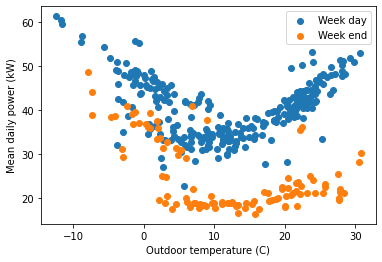

In [4]:
plt.figure()
plt.scatter(df_day['Te'][~weekend], df_day['Building 6 kW'][~weekend], label='Week day')
plt.scatter(df_day['Te'][weekend], df_day['Building 6 kW'][weekend], label='Week end')
plt.xlabel('Outdoor temperature (C)')
plt.ylabel('Mean daily power (kW)')
plt.legend()
plt.show()

Each dot is one day. This plot clearly shows two things:
* Week days and week ends are separated: in the following, we should only keep week days for the energy signature model.
* The power is clearly influenced by low and high temperatures. The trend seems close to linear on each side, confirming the choice of the energy signature model (this particular building was not chosen randomly...)

## Model definition and training

The energy signature model is an expression of the total electric consumption of a building as a function of the outdoor temperature and up to five fixed parameters. The notations of the code below match the equations given earlier.

In [5]:
def signature(T, Phi_b, T_b1, T_b2, HLC_1, HLC_2):
    """
    input : temperature T, and five parameters
    output: power P
    """

    P = Phi_b * np.ones(len(T))

    mask1 = T < T_b1
    P[mask1] += HLC_1 * (T_b1-T[mask1])

    mask2 = T > T_b2
    P[mask2] += HLC_2 * (T[mask2]-T_b2)

    return P

Now that this evaluation function is defined, we can use it in a curve fitting algorithm which will find the optimal parameters to match a given dataset: the `curve_fit` method of the `scipy.optimize` library. The week end days are filtered out. The method requires a starting point `p0` for the parameters, which we can estimate from the graph above.

In [6]:
from scipy.optimize import curve_fit

T = df_day['Te'][~weekend]
P = df_day['Building 6 kW'][~weekend]

popt, pcov = curve_fit(signature,
                       xdata = T,
                       ydata = P,
                       p0 = [20, 10, 15, 1.5, 1.5])

print('Baseline power: %.2f kW' % popt[0])
print('Lower threshold temperature: %.2f C' % popt[1])
print('Upper threshold temperature: %.2f C' % popt[2])
print('HLC (winter): %.2f kW/K' % popt[3])
print('HLC (summer): %.2f kW/K' % popt[4])

Baseline power: 34.57 kW
Lower threshold temperature: 6.53 C
Upper threshold temperature: 15.62 C
HLC (winter): 1.38 kW/K
HLC (summer): 1.18 kW/K


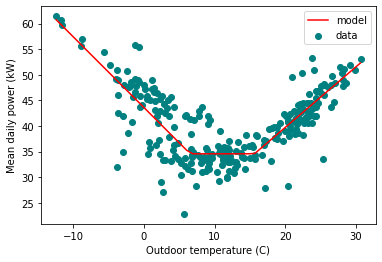

In [7]:
# Plot the results: comparing the fitted model with its data
xx = np.linspace(T.min(), T.max())
yy = signature(xx, popt[0], popt[1], popt[2], popt[3], popt[4])

plt.figure()
plt.scatter(T, P, label='data', color='teal')
plt.plot(xx, yy, label='model', color='red')
plt.xlabel('Outdoor temperature (C)')
plt.ylabel('Mean daily power (kW)')
plt.legend()
plt.show()

The model seems well fitted with the trend in the data. As this is a simple exercise, we are not analysing the indicators of statistical significance of the parameters: this will be done in other methods such as ordinary linear regression.

## Further questions

### Comparing the HLC estimation across several years

Since we have three data files for the same building, and each file is one year of measurements, we can check if the estimation of HLC is consistent across these years. In order to do this quickly, let us automate the steps described above into a single function that will return the optimal parameters as a function of only the datafile (this function requires that the labels of all files match).

In [8]:
def prepare_data(datafile):
    
    # Read data
    df = pd.read_csv(datafile)
    # Process the data
    df.set_index(pd.to_datetime(df['Date']), inplace=True)
    df['Te'] = (df['OAT']-32) * 5/9
    # New dataframe for the daily averaged data
    df_day = df.resample('D').mean()
    # Week days
    df_day['week_day'] = [df_day.index[_].weekday() for _ in range(len(df_day))]
    df_day['weekend'] = (df_day['week_day']==5) | (df_day['week_day']==6)
    
    return df_day


def estimate_hlc(datafile):
    
    df_day = prepare_data(datafile)
    
    popt, pcov = curve_fit(signature,
                           xdata = df_day['Te'][~df_day['weekend']],
                           ydata = df_day['Building 6 kW'][~df_day['weekend']],
                           p0 = [20, 10, 15, 1.5, 1.5])
    
    return popt

popt_0 = estimate_hlc('data/building60preoffice.csv')
popt_1 = estimate_hlc('data/building61duringoffice.csv')
popt_2 = estimate_hlc('data/building62postoffice.csv')

print('HLC (heating): %.2f kW/K, %.2f kW/K, %.2f kW/K' % (popt_0[3], popt_1[3], popt_2[3]))
print('HLC (cooling): %.2f kW/K, %.2f kW/K, %.2f kW/K' % (popt_0[4], popt_1[4], popt_2[4]))

HLC (heating): 1.38 kW/K, 1.25 kW/K, 2.03 kW/K
HLC (cooling): 1.18 kW/K, 0.98 kW/K, 0.89 kW/K


The values are somehow consistent, but the last year of observation shows a much higher heating consumption relatively to the outdoor temperature. This method can for instance be used to estimate the impact of energy conservation measures.

### Predicting the energy use

Another purpose of the energy signature model is to predict the energy use of a building, supposing that forecasts of the outdoor temperature are available. In the example below, we will see if the parameters learned in the first year of measurements, using `building60preoffice.csv`, can forecast the consumption observed on the next two years.

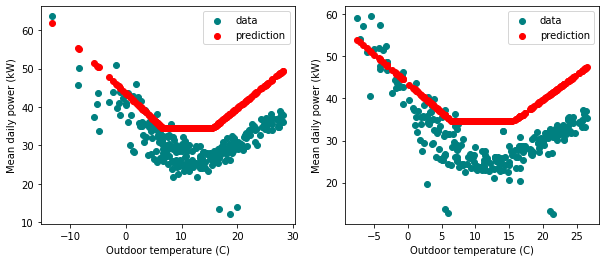

In [9]:
# Loading and processing the data files for the second and third years
df_day_1 = prepare_data('data/building61duringoffice.csv')
df_day_2 = prepare_data('data/building62postoffice.csv')

# Measured consumptions and temperatures
T_1 = df_day_1['Te'][~df_day_1['weekend']]
T_2 = df_day_2['Te'][~df_day_2['weekend']]
P_real_1 = df_day_1['Building 6 kW'][~df_day_1['weekend']]
P_real_2 = df_day_2['Building 6 kW'][~df_day_2['weekend']]
# Consumptions of the same years, but predicted by the model trained with the first dataset
P_pred_1 = signature(T_1, popt_0[0], popt_0[1], popt_0[2], popt_0[3], popt_0[4])
P_pred_2 = signature(T_2, popt_0[0], popt_0[1], popt_0[2], popt_0[3], popt_0[4])

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(T_1, P_real_1, label='data', color='teal')
plt.scatter(T_1, P_pred_1, label='prediction', color='red')
plt.xlabel('Outdoor temperature (C)')
plt.ylabel('Mean daily power (kW)')
plt.legend()
plt.subplot(122)
plt.scatter(T_2, P_real_2, label='data', color='teal')
plt.scatter(T_2, P_pred_2, label='prediction', color='red')
plt.xlabel('Outdoor temperature (C)')
plt.ylabel('Mean daily power (kW)')
plt.legend()
plt.show()

We can clearly see that the model trained on the first year of data overestimates the actual consumption of the next two years. The main difference seems to be the baseline consumption which has significantly decreased, although it does not seem that the HLC has. This might be the consequence of energy conservation measures concerning other energy uses than heating and cooling.